# BlackJack Game Implementation

   This non-standard blackjack game is implemented through two different RL algorithms, Monte Carlo Control and Temporal Dynamic Learning with Sarsa(0). To run the game with these two algorithms, first I defined an environment that describes the player's state according to the dealer's first card and player's total sum. The draw function describes the probability of choosing a card in the deck. The step function evalates the next state and reward based on the current state and action.  

   To call the Monte Carlo method, I generated the episodes before hand that collects the state, reward, and action for each time step. These time steps then are used to evaluate the state and action value estimates. The rewards are all collected from the entire episode at one time to calculate these estimates.
   
   In the Temporal Difference Learning method, I generated a select action function that acts according a greedy policy, and after generating episodes. The values are updated based on each of the steps from the previous episode.
   
To run the program: 
   Type  jupyter nbconvert --to notebook --execute SahithiBlackJack.ipynb into the terminal 

# Environment

In [1]:
import numpy as np
import random
import csv
import sys
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from collections import defaultdict

In [2]:
cards = [1,2,3,4,5,6,7,8,9,10] 
card_color_list = [-1,1] #red = -1, black = 1
actions = [0,1] #hit = 0, stick= 1
episode=[]
rewards=[]

In [3]:
#k is the number of cards player currently has
def draw(draw_ct):
    if (draw_ct==0): 
        card_num = np.random.choice(cards)
        card_color = 1
    else:
        card_num = np.random.choice(cards)
        card_color = random.choices(card_color_list, weights = (1/3, 2/3), k= 1)
        card_color = card_color[0]
    return card_num * card_color

In [4]:
f = open('checkDraw.csv','w')
black_ct=0
for i in range(1,1001):
    card=draw(1)
    card_abs=abs(card)
    color=int(card/card_abs)
    if color==1:
        black_ct+=1
    freq=round((black_ct/i),2)
    
    f.write("{}, {}, {}\n".format(card_abs,color,freq))
f.close()

In [5]:
def step(s, a): 
    (df,ps) = s
    if a==0:
        ps += draw(1)
        if (ps<0 or ps>21):
            return (0,0), -1
        return (df,ps),0
    else:
        dealer_sum=df
        while True:
            if dealer_sum>=0 and dealer_sum<17:
                dealer_sum+=draw(1)
            else:
                break
        if dealer_sum<0 or dealer_sum>21:
            return (0,0), 1
        elif (dealer_sum==ps):
            return (0,0), 0
        elif (dealer_sum>ps):
            return (0,0), -1
        else:
            return (0,0), 1

In [6]:
f = open('checkStepDealer1Player1Action0.csv','w')
outcomes = np.zeros([11,22,3])
for i in range(1,1001):
    (df,ps),rw=step((1,1),0)
    #print("i = ",i," ==> df: ",df,"; ps: ",ps,"; rw: ",rw)
    outcomes[df][ps][rw+1] += 1
    ct=outcomes[df][ps][rw+1]
    
    f.write("{}, {}, {}, {}\n".format(df,ps,rw,round((ct/i),3)))
f.close()
    

In [7]:
f = open('checkStepDealer2Player10Action0.csv','w')
outcomes = np.zeros([11,22,3])
for i in range(1,1001):
    (df,ps),rw=step((2,10),0)
    outcomes[df][ps][rw+1] += 1
    ct=outcomes[df][ps][rw+1]
    
    f.write("{}, {}, {}, {}\n".format(df,ps,rw,round((ct/i),3)))
f.close()

In [8]:
f = open('checkStepDealer10Player15Action1.csv','w')
outcomes = np.zeros([11,22,3])
for i in range(1,1001):
    (df,ps),rw=step((10,15),1)
    outcomes[df][ps][rw+1] += 1
    ct=outcomes[df][ps][rw+1]
    
    f.write("{}, {}, {}, {}\n".format(df,ps,rw,round((ct/i),3)))
f.close()

In [9]:
f = open('checkStepDealer1Player18Action1.csv','w')
outcomes = np.zeros([11,22,3])
for i in range(1,1001):
    (df,ps),rw=step((1,18),1)
    outcomes[df][ps][rw+1] += 1
    ct=outcomes[df][ps][rw+1]
    
    f.write("{}, {}, {}, {}\n".format(df,ps,rw,round((ct/i),3)))
f.close()

# Monte-Carlo Control

In [10]:
def generate_episode():
    global episode
    global rewards
    dealer_first_card=draw(0)
    player_sum=draw(0)
    reward=0
    #initialize the first state
    state=(dealer_first_card,player_sum)
    while True:
        #random action is taken 
        a=np.random.randint(0,2)
        new_state,reward=step(state,a)
        episode.append((state,a))
        rewards.append(reward)
        #should end after terminal state is reached
        if new_state==(0,0): #reward in (-1,1):
            break
        state=new_state

In [11]:
def monte_carlo_control():
    global episode
    global rewards
    pi = np.zeros([10,22,2])
    Counts = np.zeros([10,22,2])
    Q = np.zeros([10,22,2])
    V = np.zeros([10,22,1])
    for i in range(1000000):
        #print('Enter: ',i)
        episode=[]
        rewards=[]
        generate_episode()
        #print('eps: ', episode)
        #print('rew: ',reward)
        
        G=0
        #loop for each step in episode backwards
        for j,(s,a) in enumerate(reversed(episode)):
            dc,ps=s
            j_frw=len(rewards)-j-1
            reward=rewards[j_frw]
            G+=reward
            # check if the state and action occurs in the episode
            if (s,a) not in episode[:j_frw]:
                Counts[dc-1][ps][a] += 1
                Q[dc-1][ps][a] += (G-Q[dc-1][ps][a])/Counts[dc-1][ps][a]
                A = np.argmax(Q[dc-1][ps])
                eps = 10/(10 + np.min(Counts[dc-1][ps]))
                ct=Counts[dc-1][ps][a]
                for  temp_a in (0,1):
                    #in the case optimal action value
                    if temp_a==A:
                        pi[dc-1][ps][temp_a]=1-eps+(eps/ct)
                    else:
                        pi[dc-1][ps][temp_a]=(eps/ct)
    return Q

In [12]:
Q = monte_carlo_control()

In [13]:
f = open('checkQ.csv','w')
for i in range(10):
    for j in range(22):
        for k in range(2):
            f.write("{}, {}, {}, {}\n".format(i,j,k,Q[i][j][k]))
f.close()

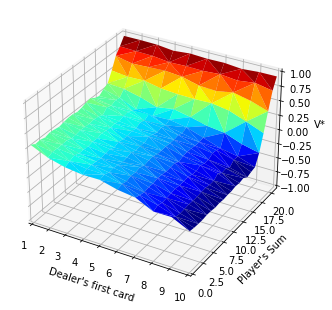

In [14]:
V = np.zeros([10,22])
#values of dealer first card
Xs = []
#values of the player's sum
Ys = []
#state values
Zs = []
for i in range(10):
    for j in range(22):
        action_value = np.max(Q[i][j])
        V[i][j] = action_value
        Xs.append(i+1)
        Ys.append(j)
        Zs.append(action_value)

fig = plt.figure()
ax = Axes3D(fig)
ax.plot_trisurf(Xs,Ys,Zs,cmap=cm.jet)
ax.set_xlabel("Dealer's first card")
ax.set_ylabel("Player's Sum")
ax.set_zlabel("V*")
ax.set_xlim(1,10)
ax.set_ylim(0,21)
ax.set_zlim(-1,1)
plt.show()

# TD Learning 

In [15]:
def select_action(S):
    global td_Q
    global td_Ct
    deal_c,player_s = S 
    epsilon = 10/(10 + np.min(td_Ct[deal_c-1][player_s]))
    n = random.uniform(0,1)
    #choosing an action based on e-greedy policy 
    if(n<epsilon):
        return np.random.randint(0,2)
    else:
        return np.argmax(td_Q[deal_c-1][player_s])

In [16]:
def generate_episode_TD():
    global td_Q
    global td_Ct
    dc=draw(0)
    ps=draw(0)
    state=(dc,ps)
    a=select_action(state)
    while True:
        td_Ct[dc-1][ps][a] += 1
        new_state,reward=step(state,a)
        new_a=select_action(new_state)
        ndc, nps = new_state
        alpha=1/(td_Ct[dc-1][ps][a])
        #in the case that it is a terminal state
        if (ndc,nps) == (0,0):
            td_Q[dc-1][ps][a] += alpha * (reward + 0 - td_Q[dc-1][ps][a])
        else:
            td_Q[dc-1][ps][a] += alpha * (reward + td_Q[ndc-1][nps][new_a] - td_Q[dc-1][ps][a])
            
        state=new_state
        dc,ps=state
        a=new_a
        if new_state == (0,0):
            break

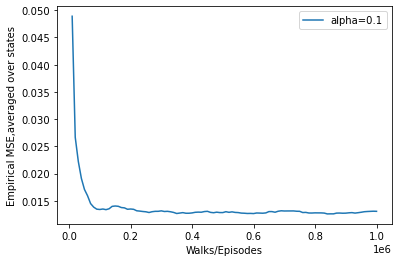

In [17]:
from sklearn.metrics import mean_squared_error
td_Q = np.zeros([10,22,2])
td_Ct = np.zeros([10,22,2])
mse_diff=[]
enc_ct=[]
#run for a million episodes
for x in range(1,1000001):
    generate_episode_TD()
    #output the MSE at every 10,000 episodes
    if x%10000==0:
        lin_mQ = []
        lin_tdQ = []
        for i in range(10):
            for j in range(22):
                for k in range(2):
                    lin_mQ.append(Q[i][j][k])
                    lin_tdQ.append(td_Q[i][j][k])
                
        mse_diff.append(mean_squared_error(lin_tdQ,lin_mQ))
        enc_ct.append(x)
    
#print(mse_diff)
plt.plot(enc_ct,mse_diff, label='alpha=0.1')
plt.xlabel('Walks/Episodes')
plt.ylabel('Empirical MSE,averaged over states')
plt.legend()
plt.show()

# Discussion

In this game, the pros of bootstrapping or implementing blackjack through TD methods include less variance meaning and faster convergence. In other words, the TD Sarsa(0) implementation only depends on the last few previous steps to arrive to at a value estimate compared to the Monte Carlo implementation, which takes into consideration of all the rewards and steps to come to this similar estimate. Cons of TD implementation include that the estimate is biased since the Q values are only estimated based on the current reward rather than estimating from actual rewards received. Since we are already estimating based on not so much of an accurate estimate, as we keep iterating over many episodes, the model will estimate to an incorrect value function.

Since one of the benefits of TD methods is faster convergence, TD methods would be better for this game in particular since the red cards will keep bringing the value down and the episodes will be longer overall to evaluate the estimates when using the MC method. Ultimately, bootstrapping will make it converge faster. However, since the regular blackjack game only adds the card values despite the color, the Monte Carlo implementation would be better and generate more accurate estimates for the regular blackjack game. 